In [32]:
import os
print(len(os.listdir("/home/qhy/data/Face Mask Dataset/Test/WithMask")))
print(len(os.listdir("/home/qhy/data/Face Mask Dataset/Test/WithoutMask")))
print(len(os.listdir("/home/qhy/data/Face Mask Dataset/Train/WithMask")))
print(len(os.listdir("/home/qhy/data/Face Mask Dataset/Train/WithoutMask")))
print(len(os.listdir("/home/qhy/data/Face Mask Dataset/Validation/WithMask")))
print(len(os.listdir("/home/qhy/data/Face Mask Dataset/Validation/WithoutMask")))

483
509
5000
5000
400
400


In [3]:
import numpy as np
import cv2
import os
import tqdm
# img_h, img_w = 32, 32
img_h, img_w = 48, 48   #根据自己数据集适当调整，影响不大
means, stdevs = [], []
img_list = []
 
imgs_path = '/home/qhy/data/Face Mask Dataset/Train/WithMask'
imgs_path2 = '/home/qhy/data/Face Mask Dataset/Train/WithoutMask'

imgs_path_list = os.listdir(imgs_path) + os.listdir(imgs_path2) 
 
len_ = len(imgs_path_list)
i = 0
for item in tqdm.tqdm(imgs_path_list):
    img = cv2.imread(os.path.join(imgs_path,item))
    try :
        img = cv2.resize(img,(img_w,img_h))
        img = img[:, :, :, np.newaxis]
        img_list.append(img)
    except:
        pass
    i += 1
 
imgs = np.concatenate(img_list, axis=3)
imgs = imgs.astype(np.float32) / 255.
 
for i in range(3):
    pixels = imgs[:, :, i, :].ravel()  # 拉成一行
    means.append(np.mean(pixels))
    stdevs.append(np.std(pixels))
 
# BGR --> RGB ， CV读取的需要转换，PIL读取的不用转换
means.reverse()
stdevs.reverse()
 
print("normMean = {}".format(means))
print("normStd = {}".format(stdevs))


 50%|████▉     | 4962/10000 [00:04<00:04, 1187.23it/s][ WARN:0@187.765] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/qhy/data/Face Mask Dataset/Train/WithMask/2750.png'): can't open/read file: check file path/integrity
[ WARN:0@187.765] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/qhy/data/Face Mask Dataset/Train/WithMask/2486.png'): can't open/read file: check file path/integrity
[ WARN:0@187.766] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/qhy/data/Face Mask Dataset/Train/WithMask/3585.png'): can't open/read file: check file path/integrity
[ WARN:0@187.766] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/qhy/data/Face Mask Dataset/Train/WithMask/3729.png'): can't open/read file: check file path/integrity
[ WARN:0@187.766] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/qhy/data/Face Mask

normMean = [0.5364829, 0.47852907, 0.45479727]
normStd = [0.28900605, 0.28060046, 0.28859267]


In [4]:
# dataset 
from torchvision import datasets
from torchvision import transforms
import torch

mean = [0.5364829, 0.47852907, 0.45479727]
std = [0.28900605, 0.28060046, 0.28859267]
resolution = 32
transform_train = transforms.Compose([
    transforms.Resize((resolution,resolution)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
num_classes = 2
# train_dataset = pyvww.pytorch.VisualWakeWordsClassification(root="/home/qhy/data/coco2017/all2017", 
#                     annFile="/home/qhy/data/coco2017/annotations/vww/instances_train.json",transform=transform_train)
# val_dataset = pyvww.pytorch.VisualWakeWordsClassification(root="/home/qhy/data/coco2017/all2017", 
#                     annFile="/home/qhy/data/coco2017/annotations/vww/instances_val.json",transform=transform_train)

train_dataset = datasets.ImageFolder("/home/qhy/data/Face Mask Dataset/Train",transform=transform_train)
val_dataset = datasets.ImageFolder("/home/qhy/data/Face Mask Dataset/Test",transform=transform_train) 

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    sampler=None)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    sampler=None)




/home/qhy/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [151]:
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint


def make_layer(stage_num, layer_num, channel_num_in, channel_num_out, op_type,
               with_pool,pool_type):
    channel_nums_in = [channel_num_in] + [channel_num_out] * (layer_num - 1)
    layers = []
    if stage_num == 0 :
        first_layer_stride = 1
    else:
        first_layer_stride = 2
    if with_pool == True:
        if pool_type == "avgpool":
            layers.append(("avgpool", nn.AvgPool2d(2, 2)))
        else:
            layers.append(("maxpool", nn.MaxPool2d(2, 2)))
        if op_type == 'vgg':
            layers.append(("stage_{}_0_vgg".format(stage_num),
                           VGGBlock(channel_num_in,
                                    channel_num_out,
                                    kernel_size=3,
                                    stride=1)))
            layers += [("stage_{}_{}_vgg".format(stage_num, i),
                        VGGBlock(channel_num_out, channel_num_out, 3))
                       for i in range(1, layer_num)]
        else:
            layers.append(("stage_{}_0_repvgg".format(stage_num),
                           RepVGGBlock(channel_num_in,
                                       channel_num_out,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)))
            layers += [("stage_{}_{}_repvgg".format(stage_num, i),
                        RepVGGBlock(channel_num_out,
                                    channel_num_out,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1)) for i in range(1, layer_num)]

    else:
        if op_type == 'vgg':
            layers.append(("stage_{}_0_vgg".format(stage_num),
                           VGGBlock(channel_num_in,
                                    channel_num_out,
                                    kernel_size=3,
                                    stride=first_layer_stride)))
            layers += [("stage_{}_{}_vgg".format(stage_num, i),
                        VGGBlock(channel_num_out, channel_num_out, 3))
                       for i in range(1, layer_num)]
        else:
            layers.append(("stage_{}_0_repvgg".format(stage_num),
                           RepVGGBlock(channel_num_in,
                                       channel_num_out,
                                       kernel_size=3,
                                       padding=1,
                                       stride=first_layer_stride)))
            layers += [("stage_{}_{}_repvgg".format(stage_num, i),
                        RepVGGBlock(channel_num_out,
                                    channel_num_out,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1)) for i in range(1, layer_num)]
    return nn.Sequential(OrderedDict(layers))
def VGGBlock(in_channels,
             out_channels,
             kernel_size,
             stride=1,
             padding=1,
             dilation=1,
             groups=1,
             padding_mode='zeros'):
    conv2d = nn.Conv2d(in_channels,
                       out_channels,
                       kernel_size=kernel_size,
                       stride = stride,
                       padding=1,
                       dilation=1,
                       groups=1,
                       padding_mode='zeros')
    layers = nn.Sequential(
        OrderedDict([("conv", conv2d), ("bn", nn.BatchNorm2d(out_channels)),
                     ("relu", nn.ReLU(inplace=True))]))
    return layers

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.pool = False
        self.stage_0 = make_layer(0, 1, 3, 64, "vgg",
               with_pool=False,pool_type="None")
        # self.pool = torch.nn.MaxPool2d(2,2)
        self.stage_1 = make_layer(1, 1, 64, 16, "vgg",
               with_pool=False,pool_type="None")
        self.stage_2 = make_layer(2, 1, 16, 8, "vgg",
               with_pool=False,pool_type="None")
        self.stage_3 = make_layer(3, 1, 8, 1, "vgg",
               with_pool=False,pool_type="None")
        # self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        # self.linear = nn.Linear(196, 32)
        self.linear_2 = nn.Linear(196, num_classes)
        
    def forward(self, input):
        out = self.stage_0(input)
        # out = self.pool(out)
        out = self.stage_1(out)
        # out = self.pool(out)
        out = self.stage_2(out)
        out = self.stage_3(out)
        # out = self.gap(out)
        # print(out.shape)
        # out = self.linear(out.view(out.size(0), -1))
        out = self.linear_2(out.view(out.size(0), -1))
        
        # out = self.classifier(out.view(out.size(0), -1))
        return out
model = Net(2)
input = torch.randn(3,3,112,112)
out = model(input)

In [23]:
import yaml
from easydict import EasyDict
import sys
sys.path.append("/home/qhy/Reserach/AICAS")
from models import model_mask as M

config_path = "/home/qhy/Reserach/AICAS/config/mask/0-stage-2_4_2_1-ratio-0.375_0.375_0.5_0.25-op-vgg_repvgg_vgg_repvgg-pool-False_False_False_False_False-pool_type-None_None_None_None_None-mask-48.yaml"
config = EasyDict(yaml.full_load(open(config_path)))
# config = {"model" : 
#         {"layer_num_max":[64,64,128,256,512],
#             "op_type":["repvgg","repvgg","vgg","repvgg","vgg"],
#           "pool_type":[None,None,None,None,None,None,],
#           "with_pool":[False,False,False,False,False,False,],
#           "stage_layer":[1,1,1,1,1],
#           "stage_ratio":[0.125,0.125,0.125,0.125,0.125]},
#         "dataset": "mask",
#           }
model = M.Net(config, num_classes)

In [21]:
ExpLR.step()

Epoch  0/60


100%|██████████| 31/31 [00:00<00:00, 46.22it/s]


lr is :0.02000000 Loss is :0.0025,Train Accuracy is:95.6700%,Test Accuracy is:51.3105%
Epoch  1/60


100%|██████████| 31/31 [00:00<00:00, 45.86it/s]


lr is :0.01988304 Loss is :0.0037,Train Accuracy is:92.2600%,Test Accuracy is:51.3105%
Epoch  2/60


100%|██████████| 31/31 [00:00<00:00, 44.86it/s]


lr is :0.01953504 Loss is :0.0036,Train Accuracy is:92.7600%,Test Accuracy is:51.3105%
Epoch  3/60


100%|██████████| 31/31 [00:00<00:00, 45.91it/s]


lr is :0.01896456 Loss is :0.0033,Train Accuracy is:93.6200%,Test Accuracy is:51.3105%
Epoch  4/60


100%|██████████| 31/31 [00:00<00:00, 45.77it/s]


lr is :0.01818566 Loss is :0.0029,Train Accuracy is:94.8400%,Test Accuracy is:51.3105%
Epoch  5/60


100%|██████████| 31/31 [00:00<00:00, 46.17it/s]


lr is :0.01721751 Loss is :0.0024,Train Accuracy is:95.8800%,Test Accuracy is:51.3105%
Epoch  6/60


100%|██████████| 31/31 [00:00<00:00, 43.66it/s]


lr is :0.01608396 Loss is :0.0019,Train Accuracy is:97.3900%,Test Accuracy is:51.3105%
Epoch  7/60


100%|██████████| 31/31 [00:00<00:00, 44.96it/s]


lr is :0.01481291 Loss is :0.0015,Train Accuracy is:97.5400%,Test Accuracy is:51.3105%
Epoch  8/60


100%|██████████| 31/31 [00:00<00:00, 46.70it/s]


lr is :0.01343566 Loss is :0.0012,Train Accuracy is:98.3200%,Test Accuracy is:51.3105%
Epoch  9/60


100%|██████████| 31/31 [00:00<00:00, 45.66it/s]


lr is :0.01198613 Loss is :0.0009,Train Accuracy is:98.7900%,Test Accuracy is:51.4113%
Epoch  10/60


100%|██████████| 31/31 [00:00<00:00, 44.89it/s]


lr is :0.01050000 Loss is :0.0007,Train Accuracy is:98.8000%,Test Accuracy is:52.0161%
Epoch  11/60


100%|██████████| 31/31 [00:00<00:00, 47.05it/s]


lr is :0.00901387 Loss is :0.0006,Train Accuracy is:98.8200%,Test Accuracy is:62.5000%
Epoch  12/60


100%|██████████| 31/31 [00:00<00:00, 42.74it/s]


lr is :0.00756434 Loss is :0.0005,Train Accuracy is:99.0000%,Test Accuracy is:86.3911%
Epoch  13/60


100%|██████████| 31/31 [00:00<00:00, 46.12it/s]


lr is :0.00618709 Loss is :0.0004,Train Accuracy is:99.6800%,Test Accuracy is:97.8831%
Epoch  14/60


100%|██████████| 31/31 [00:00<00:00, 42.83it/s]


lr is :0.00491604 Loss is :0.0003,Train Accuracy is:99.9600%,Test Accuracy is:99.6976%
Epoch  15/60


100%|██████████| 31/31 [00:00<00:00, 45.07it/s]


lr is :0.00378249 Loss is :0.0003,Train Accuracy is:99.9200%,Test Accuracy is:99.6976%
Epoch  16/60


100%|██████████| 31/31 [00:00<00:00, 45.66it/s]


lr is :0.00281434 Loss is :0.0002,Train Accuracy is:99.9200%,Test Accuracy is:99.6976%
Epoch  17/60


100%|██████████| 31/31 [00:00<00:00, 46.06it/s]


lr is :0.00203544 Loss is :0.0002,Train Accuracy is:99.9200%,Test Accuracy is:99.6976%
Epoch  18/60


100%|██████████| 31/31 [00:00<00:00, 46.61it/s]


lr is :0.00146496 Loss is :0.0002,Train Accuracy is:99.9200%,Test Accuracy is:99.6976%
Epoch  19/60


100%|██████████| 31/31 [00:00<00:00, 46.10it/s]


lr is :0.00111696 Loss is :0.0002,Train Accuracy is:99.9200%,Test Accuracy is:99.6976%
Epoch  20/60


100%|██████████| 31/31 [00:00<00:00, 45.79it/s]


lr is :0.02000000 Loss is :0.0001,Train Accuracy is:99.9900%,Test Accuracy is:51.3105%
Epoch  21/60


100%|██████████| 31/31 [00:00<00:00, 42.93it/s]


lr is :0.01997071 Loss is :0.0007,Train Accuracy is:98.8000%,Test Accuracy is:51.3105%
Epoch  22/60


100%|██████████| 31/31 [00:00<00:00, 45.33it/s]


lr is :0.01988304 Loss is :0.0006,Train Accuracy is:98.8000%,Test Accuracy is:51.7137%
Epoch  23/60


100%|██████████| 31/31 [00:00<00:00, 45.81it/s]


lr is :0.01973751 Loss is :0.0004,Train Accuracy is:98.9200%,Test Accuracy is:69.4556%
Epoch  24/60


100%|██████████| 31/31 [00:00<00:00, 45.68it/s]


lr is :0.01953504 Loss is :0.0003,Train Accuracy is:99.3500%,Test Accuracy is:96.8750%
Epoch  25/60


100%|██████████| 31/31 [00:00<00:00, 45.75it/s]


lr is :0.01927686 Loss is :0.0001,Train Accuracy is:99.9200%,Test Accuracy is:99.6976%
Epoch  26/60


100%|██████████| 31/31 [00:00<00:00, 45.65it/s]


lr is :0.01896456 Loss is :0.0001,Train Accuracy is:99.9000%,Test Accuracy is:97.9839%
Epoch  27/60


100%|██████████| 31/31 [00:00<00:00, 44.68it/s]


lr is :0.01860008 Loss is :0.0001,Train Accuracy is:99.9200%,Test Accuracy is:99.6976%
Epoch  28/60


100%|██████████| 31/31 [00:00<00:00, 46.93it/s]


lr is :0.01818566 Loss is :0.0001,Train Accuracy is:99.9000%,Test Accuracy is:99.6976%
Epoch  29/60


100%|██████████| 31/31 [00:00<00:00, 46.17it/s]


lr is :0.01772386 Loss is :0.0001,Train Accuracy is:99.9100%,Test Accuracy is:99.6976%
Epoch  30/60


100%|██████████| 31/31 [00:00<00:00, 45.51it/s]


lr is :0.01721751 Loss is :0.0001,Train Accuracy is:99.9100%,Test Accuracy is:99.6976%
Epoch  31/60


100%|██████████| 31/31 [00:00<00:00, 47.12it/s]


lr is :0.01666976 Loss is :0.0001,Train Accuracy is:99.9400%,Test Accuracy is:99.6976%
Epoch  32/60


100%|██████████| 31/31 [00:00<00:00, 46.32it/s]


lr is :0.01608396 Loss is :0.0001,Train Accuracy is:99.9500%,Test Accuracy is:99.6976%
Epoch  33/60


100%|██████████| 31/31 [00:00<00:00, 44.67it/s]


lr is :0.01546374 Loss is :0.0001,Train Accuracy is:99.9600%,Test Accuracy is:99.6976%
Epoch  34/60


100%|██████████| 31/31 [00:00<00:00, 46.66it/s]


lr is :0.01481291 Loss is :0.0000,Train Accuracy is:99.9600%,Test Accuracy is:99.6976%
Epoch  35/60


100%|██████████| 31/31 [00:00<00:00, 46.12it/s]


lr is :0.01413549 Loss is :0.0000,Train Accuracy is:99.9700%,Test Accuracy is:99.6976%
Epoch  36/60


100%|██████████| 31/31 [00:00<00:00, 46.17it/s]


lr is :0.01343566 Loss is :0.0000,Train Accuracy is:99.9600%,Test Accuracy is:99.6976%
Epoch  37/60


100%|██████████| 31/31 [00:00<00:00, 45.76it/s]


lr is :0.01271773 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  38/60


100%|██████████| 31/31 [00:00<00:00, 45.44it/s]


lr is :0.01198613 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  39/60


100%|██████████| 31/31 [00:00<00:00, 42.71it/s]


lr is :0.01124536 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  40/60


100%|██████████| 31/31 [00:00<00:00, 45.66it/s]


lr is :0.01050000 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  41/60


100%|██████████| 31/31 [00:00<00:00, 45.13it/s]


lr is :0.00975464 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  42/60


100%|██████████| 31/31 [00:00<00:00, 46.29it/s]


lr is :0.00901387 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  43/60


100%|██████████| 31/31 [00:00<00:00, 45.50it/s]


lr is :0.00828227 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  44/60


100%|██████████| 31/31 [00:00<00:00, 45.93it/s]


lr is :0.00756434 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  45/60


100%|██████████| 31/31 [00:00<00:00, 46.43it/s]


lr is :0.00686451 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  46/60


100%|██████████| 31/31 [00:00<00:00, 44.16it/s]


lr is :0.00618709 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  47/60


100%|██████████| 31/31 [00:00<00:00, 44.65it/s]


lr is :0.00553626 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  48/60


100%|██████████| 31/31 [00:00<00:00, 43.95it/s]


lr is :0.00491604 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  49/60


100%|██████████| 31/31 [00:00<00:00, 45.83it/s]


lr is :0.00433024 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  50/60


100%|██████████| 31/31 [00:00<00:00, 45.99it/s]


lr is :0.00378249 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  51/60


100%|██████████| 31/31 [00:00<00:00, 45.71it/s]


lr is :0.00327614 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  52/60


100%|██████████| 31/31 [00:00<00:00, 45.45it/s]


lr is :0.00281434 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  53/60


100%|██████████| 31/31 [00:00<00:00, 45.69it/s]


lr is :0.00239992 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  54/60


100%|██████████| 31/31 [00:00<00:00, 45.47it/s]


lr is :0.00203544 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  55/60


100%|██████████| 31/31 [00:00<00:00, 43.35it/s]


lr is :0.00172314 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  56/60


100%|██████████| 31/31 [00:00<00:00, 46.47it/s]


lr is :0.00146496 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  57/60


100%|██████████| 31/31 [00:00<00:00, 45.13it/s]


lr is :0.00126249 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  58/60


100%|██████████| 31/31 [00:00<00:00, 47.09it/s]


lr is :0.00111696 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
Epoch  59/60


100%|██████████| 31/31 [00:00<00:00, 45.99it/s]


lr is :0.00102929 Loss is :0.0000,Train Accuracy is:99.9800%,Test Accuracy is:99.6976%
tensor(99.6976, device='cuda:0')


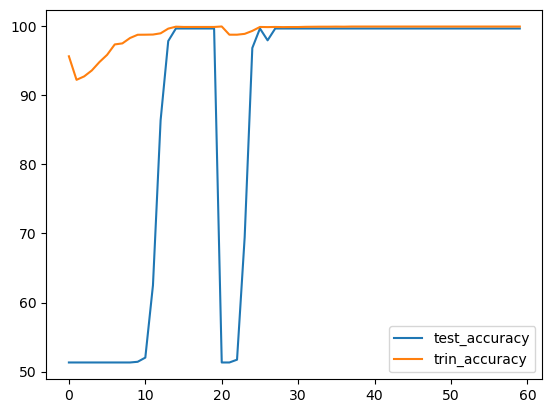

In [24]:
# 对模型进行训练和参数优化
cnn_model = model
cnn_model.cuda()
# learning_rate = 0.00002 for adam
learning_rate = 0.02
import tqdm 
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(),lr=learning_rate)
# ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
ExpLR = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=0.001)


n_epochs = 60
predict_acc = []
train_acc = []
best_acc = 0
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0.0
    print("Epoch  {}/{}".format(epoch, n_epochs))
    num_iter = 0
    for data in tqdm.tqdm(train_loader):
        num_iter += 1
        X_train, y_train = data
        X_train, y_train = X_train.cuda(), y_train.cuda()
        outputs = cnn_model(X_train)
        _, pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = loss_func(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
        if num_iter > 200:
            break
    testing_correct = 0.0
    for data in tqdm.tqdm(val_loader):
        X_test, y_test = data
        # X_test, y_test = Variable(X_test), Variable(y_test)
        X_test, y_test = X_test.cuda(), y_test.cuda()
        outputs = cnn_model(X_test)
        _, pred = torch.max(outputs, 1) #返回每一行中最大值的那个元素，且返回其索引
        testing_correct += torch.sum(pred == y_test.data)
        # print(testing_correct)
    test_Acc = 100 * testing_correct / len(val_dataset)
    train_Acc = 100 * running_correct / len(train_dataset)
    print("lr is :{:.8f} Loss is :{:.4f},Train Accuracy is:{:.4f}%,Test Accuracy is:{:.4f}%".format(
        ExpLR.get_last_lr()[0],
        running_loss / len(train_dataset), train_Acc,
        test_Acc))
    if(test_Acc>best_acc):
        best_acc=test_Acc
        best_cnn_model = cnn_model
    ExpLR.step()
    predict_acc.append(100 * testing_correct / len(val_dataset))
    train_acc.append(100 * running_correct / len(train_dataset))
savepath = "-".join(config["model"]["op_type"])+'-Pool-'+"-".join([str(i) for i in config["model"]["with_pool"]])+'-Ratio-'+"-".join([str(i) for i in config["model"]["stage_ratio"]])\
+'-layer-'+"-".join([str(i) for i in config["model"]["stage_layer"]])+"-lr-"+str(learning_rate)+'-res-'+str(resolution)+'.pth'
torch.save({"model":best_cnn_model.state_dict(),"lr":learning_rate,"acc":best_acc},"/home/qhy/Reserach/AICAS/log/mask/"+savepath)

plt.plot(range(n_epochs),[ predict_acc[i].detach().cpu().numpy() for i in range(n_epochs)],label = "tç_accuracy")
plt.plot(range(n_epochs),[ train_acc[i].detach().cpu().numpy() for i in range(n_epochs)],label = "trin_accuracy")
plt.legend()
print(max(predict_acc))

'vgg-vgg-vgg-vgg-vgg-Pool-False-False-False-False-False-False-Ratio-0.5-0.5-0.5-0.5-0.5-layer-1-1-1-1-1-lr-2e-05.pth'

In [4]:
ExpLR.step()
ExpLR.get_last_lr()[0]

2.1520920080445844e-43

|resolution|lr|best|
|-|-|-|
|32|0.0006|79|
|64|0.0006|72|
|64|0.0006|76|
|112|0.0005|66|
|112|0.0004|77|

|resolution|lr|best|
|-|-|-|
|112|0.0003|74|
|32|0.0004|76|

|resolution|lr|best|
|64|0.00007|99+|
|48|0.00004|

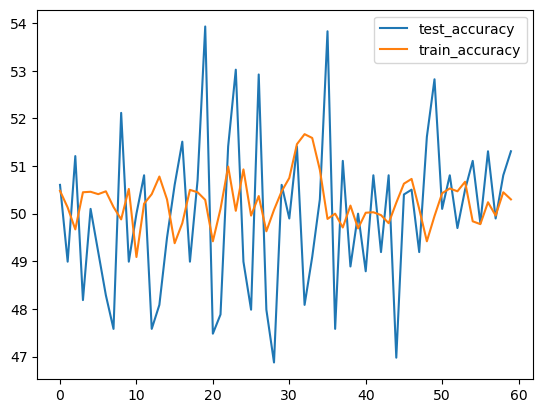

In [9]:
# 添加linear2之前精度72.
# 添加linear2之后精度77.56 50epoch
import matplotlib.pyplot as plt
plt.plot(range(60),[ predict_acc[i].detach().cpu().numpy() for i in range(60)],label = "test_accuracy")
plt.plot(range(60),[ train_acc[i].detach().cpu().numpy() for i in range(60)],label = "train_accuracy")
plt.legend()

In [32]:
model.load_state_dict(torch.load("/home/qhy/Reserach/AICAS/log/mask/0-stage-2_4_2_1-ratio-0.375_0.375_0.5_0.25-op-vgg_repvgg_vgg_repvgg-pool-False_False_False_False_False-pool_type-None_None_None_None_None-mask-48/best_ckpt.pth")['model']) 
val_dataset_1 = datasets.ImageFolder("/home/qhy/data/mask_classification/train",transform=transform_train) 
val_dataset_2 = datasets.ImageFolder("/home/qhy/data/Face Mask Dataset/Test",transform=transform_train) 
val_dataset_3 = datasets.ImageFolder("/home/qhy/data/mask_classification/test",transform=transform_train) 
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

def merge_datasets(dataset, sub_dataset):
    '''
        需要合并的Attributes:
            classes (list): List of the class names sorted alphabetically.
            class_to_idx (dict): Dict with items (class_name, class_index).
            samples (list): List of (sample path, class_index) tuples
            targets (list): The class_index value for each image in the dataset
    '''
    # 合并 classes
    dataset.classes.extend(sub_dataset.classes)
    dataset.classes = sorted(list(set(dataset.classes)))
    # 合并 class_to_idx
    dataset.class_to_idx.update(sub_dataset.class_to_idx)
    # 合并 samples
    dataset.samples.extend(sub_dataset.samples)
    # 合并 targets
    dataset.targets.extend(sub_dataset.targets)
    return dataset
val_dataset_temp = merge_datasets(val_dataset_1,val_dataset_2)
val_dataset = merge_datasets(val_dataset_temp,val_dataset_3)


val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        sampler=None)

testing_correct = 0.0
for data in tqdm.tqdm(val_loader):
            X_test, y_test = data
            # X_test, y_test = Variable(X_test), Variable(y_test)
            X_test, y_test = X_test.cuda(), y_test.cuda()
            outputs = model(X_test)
            _, pred = torch.max(outputs, 1) #返回每一行中最大值的那个元素，且返回其索引
            testing_correct += torch.sum(pred == y_test.data)
test_Acc = 100 * testing_correct / len(val_dataset)
print(test_Acc)

100%|██████████| 45/45 [00:03<00:00, 13.21it/s]

tensor(95.6704, device='cuda:0')
